### Иллюстрация пакета QuantLib-Python на искусственном примере

В этом блоке просто привожу пример готового пакета для калибровки параметров. Но так как он это делает по опционам, то для текущего этапа данный метод не подходит.

In [237]:
#!pip install QuantLib-Python

In [17]:
import QuantLib as ql
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import math

#### Hull-White 1 Factor Model 

\begin{equation}
dr_t = (\theta(t) - a r_t) dt + \sigma dW_t
\end{equation}

In [2]:
today = ql.Date(1, ql.April, 2010);
settlement= ql.Date(1, ql.April, 2013);
ql.Settings.instance().evaluationDate = today;
term_structure = ql.YieldTermStructureHandle(
    ql.FlatForward(settlement,0.04875825,ql.Actual365Fixed())
    )
index = ql.Euribor1Y(term_structure)

In [3]:
CalibrationData = namedtuple("CalibrationData", 
                             "start, length, volatility")
data = [CalibrationData(1, 5, 0.1148),
        CalibrationData(2, 4, 0.1108),
        CalibrationData(3, 3, 0.1070),
        CalibrationData(4, 2, 0.1021),
        CalibrationData(5, 1, 0.1000 )]

In [4]:
CalibrationData(1, 5, 0.1148)

CalibrationData(start=1, length=5, volatility=0.1148)

In [5]:
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_tenor = ql.Period(1, ql.Years)
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start, ql.Years),
                                   ql.Period(d.length, ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

def calibration_report(swaptions, data):
    print("-"*82)
    print("%15s %15s %15s %15s %15s" % \
    ("Model Price", "Market Price", "Implied Vol", "Market Vol", "Rel Error"))
    print("-"*82)
    cum_err = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i].volatility
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
                                          1e-5, 50, 0.0, 0.50)
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error2*rel_error2
        
        print("%15.5f %15.5f %15.5f %15.5f %15.5f" % \
        (model_price, black_price, implied_vol, market_vol, rel_error))
    print("-"*82)
    print("Cumulative Error : %15.5f" % math.sqrt(cum_err))

In [6]:
model = ql.HullWhite(term_structure);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model.params()
print("a = %6.5f, sigma = %6.5f" % (a, sigma))

a = 0.04733, sigma = 0.00820


In [7]:
calibration_report(swaptions, data)

----------------------------------------------------------------------------------
    Model Price    Market Price     Implied Vol      Market Vol       Rel Error
----------------------------------------------------------------------------------
        0.01237         0.01884         0.07526         0.11480        -0.34360
        0.01361         0.01586         0.09505         0.11080        -0.14158
        0.01218         0.01225         0.10631         0.10700        -0.00637
        0.00915         0.00821         0.11380         0.10210         0.11373
        0.00499         0.00419         0.11921         0.10000         0.19045
----------------------------------------------------------------------------------
Cumulative Error :         0.43463


Нарисуем траектории процесса при заданных параметрах.

In [8]:
sigma = 0.00820
a = 0.04733
timestep = 360
length = 4 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2015)

In [9]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

In [10]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(
    timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [11]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

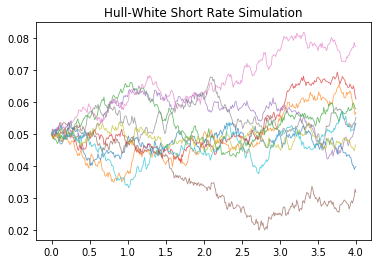

In [18]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.7)
plt.title("Hull-White Short Rate Simulation")
plt.show()